In [0]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model, model_from_json
from google.colab.patches import cv2_imshow

In [0]:
model = load_model('resnet_model.hdf5')

In [0]:
def pyramid(img, scale_factor=1.25, min_size=(64, 64),
            max_size=(960,960)):
    h, w, d = img.shape
    min_w, min_h = min_size
    max_w, max_h = max_size
    while w >= min_w and h >= min_h:
        if w <= max_w and h <= max_h:
            yield img
        w /= scale_factor
        h /= scale_factor
        img = cv2.resize(img, (int(w), int(h)),cv2.INTER_AREA)

def sliding_window(img, step=10, window_size=(64, 64)):
    img_h, img_w, img_d = img.shape
    window_h, window_w = window_size
    for y in range(0, img_w - window_w, step):
        for x in range(0, img_h - window_h, step):
            roi = img[x:x+window_w, y:y+window_h,:]
            yield (x, y, roi.reshape(1,window_h,window_w,3))

In [0]:
NMS_OVERLAP_THRESHOLD = 0.15
def nms(boxes, overlapThresh):
  if len(boxes) == 0:
    return []
  pick = []
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
  scores = boxes[:,4]
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(scores)
  while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    overlap = (w * h) / area[idxs[:last]]
    idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > overlapThresh)[0])))
  return boxes[pick]

def detect(img_path):
  pos_rects = []
  img_in = cv2.imread(img_path)
  img = np.copy(img_in)/255
  for resized in pyramid(img):
    for x, y, roi in sliding_window(resized):
      prediction = model.predict(roi)
      if prediction.item() > 0.99:
        score = prediction.item()
        h, w, d = roi.shape[1:]
        scale = img.shape[0] / float(resized.shape[0])
        pos = [int(x * scale),int(y * scale),int((x+w) * scale),int((y+h) * scale),score]
        if pos not in pos_rects: 
          pos_rects.append(pos)
  pos_rects = nms(np.asarray(pos_rects),NMS_OVERLAP_THRESHOLD)
  for x0, y0, x1, y1, score in pos_rects:
    print((int(x0), int(y0)), (int(x1), int(y1)))
    cv2.rectangle(img_in, (int(y0), int(x0)), (int(y1), int(x1)),(0, 0, 255), 2)
  cv2_imshow(img_in)
  cv2.imwrite('out.png',img_in)

(262, 712) (342, 792)
(220, 190) (284, 254)
(300, 110) (364, 174)
(109, 468) (209, 568)
(210, 310) (274, 374)


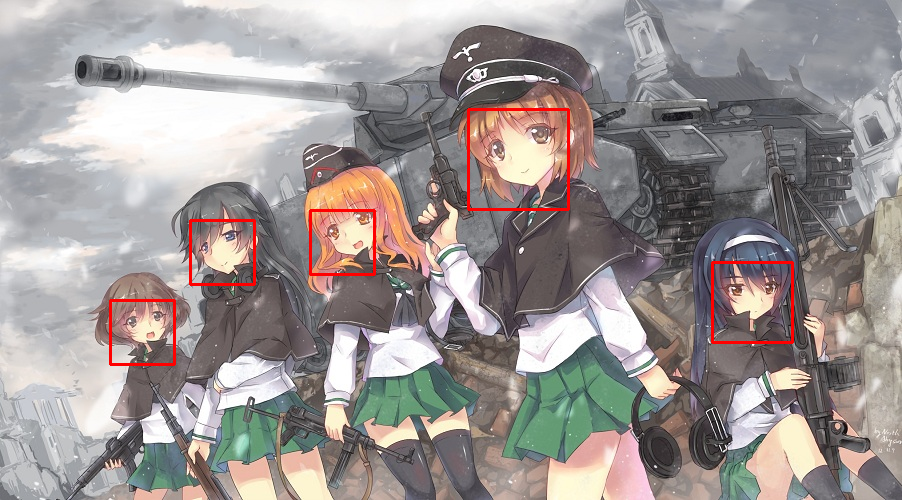

In [0]:
detect('test.png')